Now we fill na
0 attributes have na values and they are fill with corresponding mean
Now we drop identical columns
0 attriutes are dropped because of identical values
Now we do standardization
Now we do PCA
2048 features are now reduced to 39 features
40
now fit data to hyperparameter selector
{'criterion': 'entropy', 'max_depth': 270, 'max_leaf_nodes': 170, 'min_samples_split': 3, 'n_estimators': 1000}
0.9106796116504855
now we do pruning


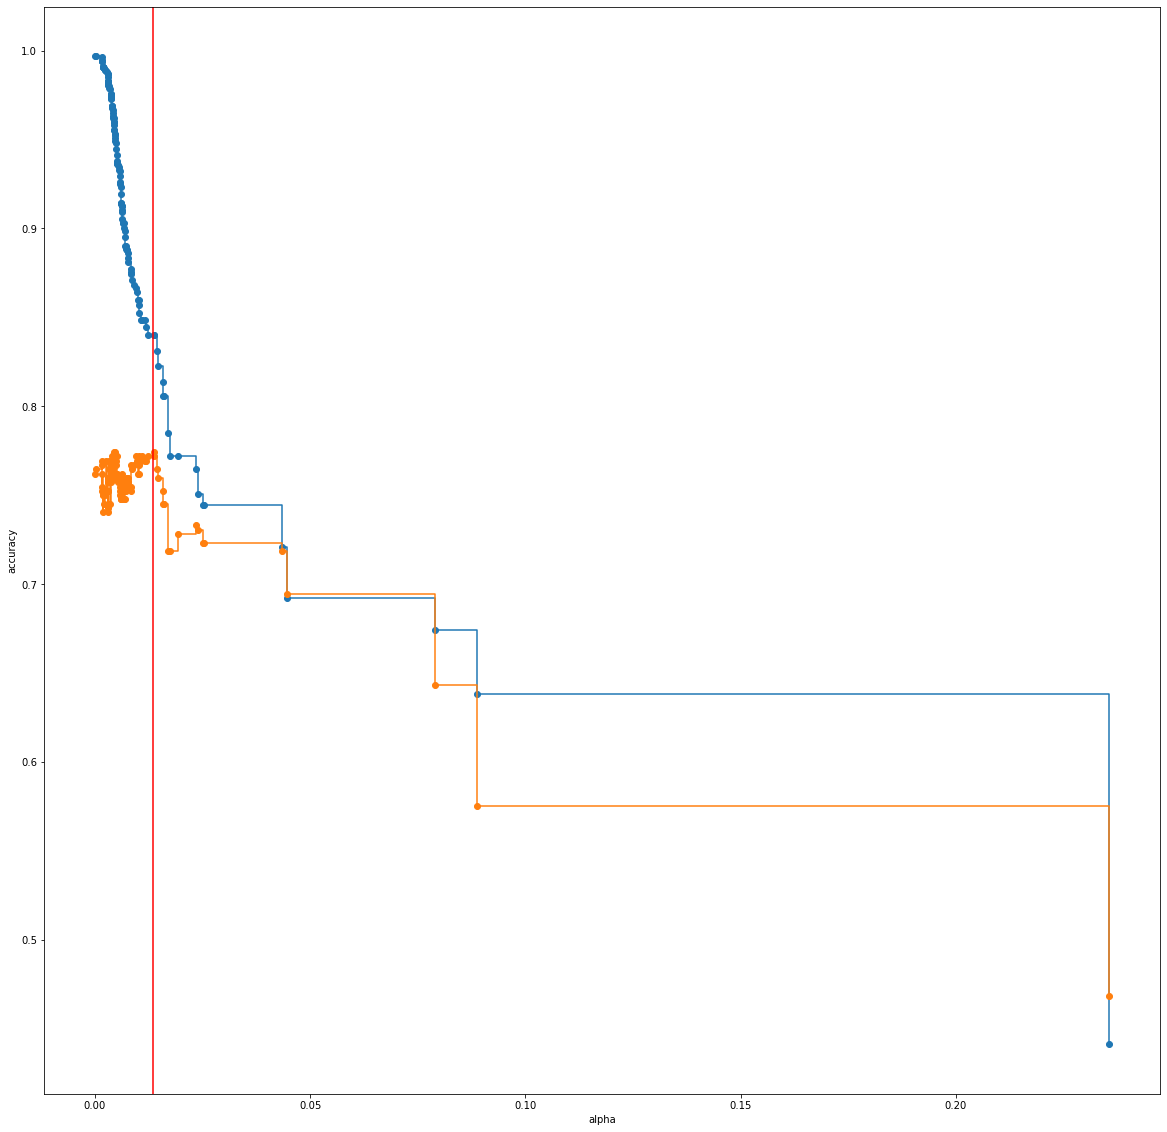

From the graph, best alpha value is 0.14
now do cross validation
[0.90291262 0.84466019 0.8592233  0.90776699 0.87864078 0.86407767
 0.90291262 0.87864078 0.75242718 0.82524272]
0.8616504854368932
finish plotting histogram
tree saved as decision_tree.png
Now i will test the model using original data
Now we fill na
0 attributes have na values and they are fill with corresponding mean
Now we drop identical columns
0 attriutes are dropped because of identical values
Now we do standardization
Now we do PCA
2048 features are now reduced to 39 features
The accuracy for my model is: 0.9.
The prediction result is as follow:

[1 0 1 2 0 0 1 0 1 2 1 1 0 2 1 1 2 1 0 1 1 2 0 1 1 1 1 1 1 1 2 0 1 2 0 1 2
 1 1 1 0 1 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 0 1 1 1 1 2 1 2 0 1 1 1 1 1 0
 1 0 1 0 0 0 0 0 0 2 0 1 1 0 0 1 0 1 2 1 1 2 0 1 0 1 0 1 0 1 1 2 0 0 2 1 1
 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 2 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1
 1 0 2 0 1 1 1 0 1 1 2 1 1 1 0 2 1 0 1 0 1 2 1 0 1 0 0 2 1 1 1 1 1 0 0 2 1


FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

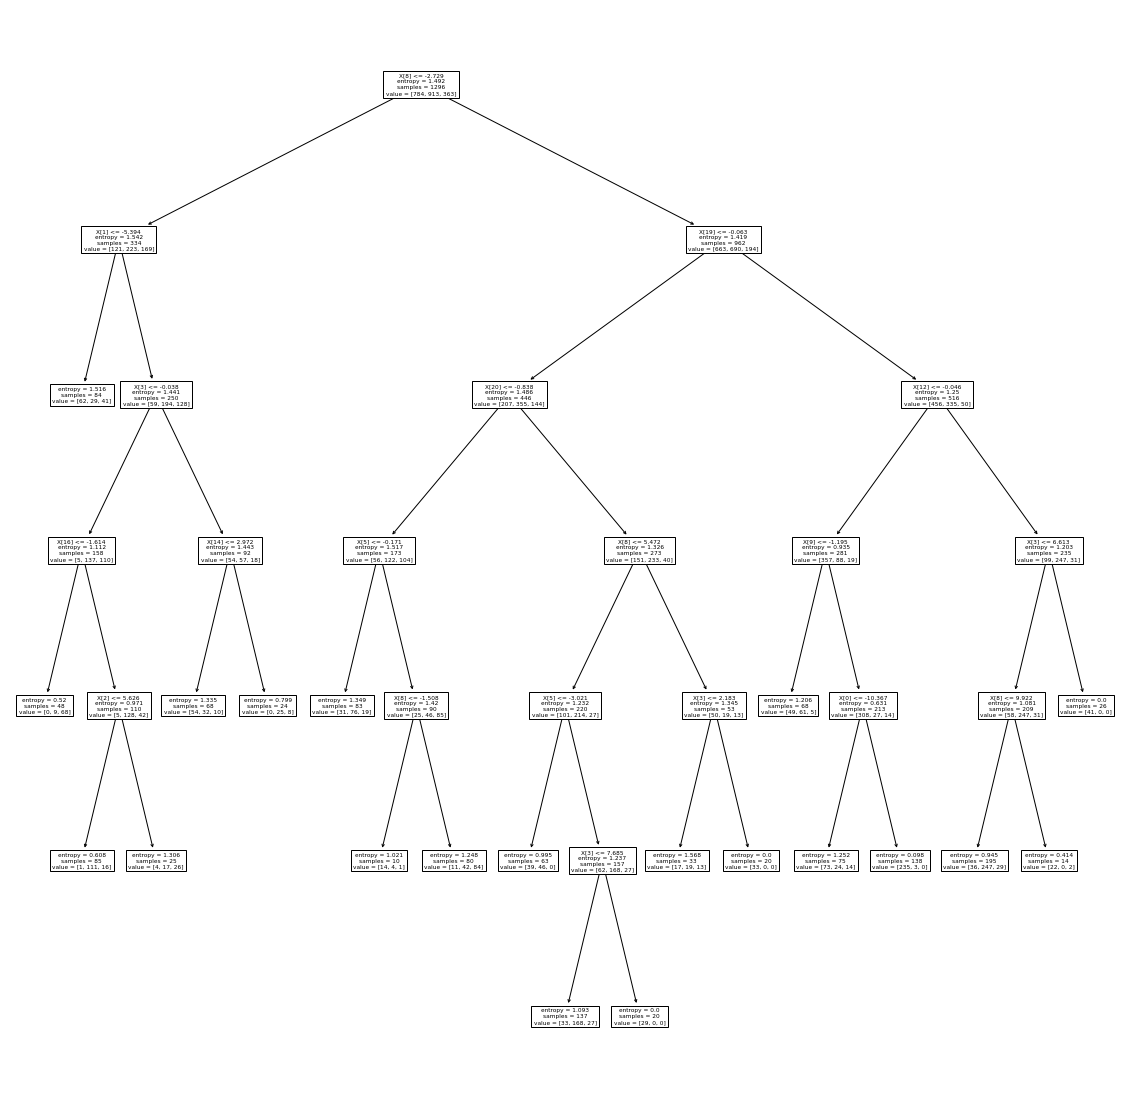

In [1]:
def preprocess(filename):
    import numpy as np
    import pandas as pd
    ds = pd.read_csv(filename)
    print('Now we fill na')
    na_count=0
    for i in ds.columns:
        if(ds[i].isnull().values.any()==True):
            mu = ds[i].mean()
            ds[i] = ds[i].fillna(mu)
            na_count +=1
    print(str(na_count)+' attributes have na values and they are fill with corresponding mean')
    print('Now we drop identical columns')
    identical_count =0
    for i in ds.columns:
        if ds[i].diff().abs().sum()==0:
            ds = ds.drop(i,1)
            identical_count +=1
    print(str(identical_count) + ' attriutes are dropped because of identical values')
    print('Now we do standardization')
    list_of_features = ds.columns.tolist()
    list_of_features.remove('label')
    from sklearn.preprocessing import StandardScaler
    for i in list_of_features:
        ds[i] = StandardScaler().fit_transform(ds[i].values.reshape(-1, 1))
    ds = get_pca(ds)
    return ds

def get_pca(ds):
    import pandas as pd
    import numpy as np
    from sklearn.decomposition import PCA
    print('Now we do PCA')
    list_of_features = ds.columns.tolist()
    list_of_features.remove('label')
    nc= len(list_of_features)
    pca = PCA(n_components=nc)
    pca.fit(ds[list_of_features])
    ncpca = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.9) + 1
    pca = PCA(ncpca).fit(ds[list_of_features])
    components = pca.transform(ds[list_of_features])
    reduced_df_train = pd.DataFrame(components)
    reduced_df_train['label'] = ds['label']
    print(str(nc)+' features are now reduced to '+str(ncpca)+' features')
    return reduced_df_train

def prun(tree,x_tr,x_ts,y_tr,y_ts,best_paras):
    import matplotlib.pyplot as plt
    from sklearn.tree import DecisionTreeClassifier
    path = tree.cost_complexity_pruning_path(x_tr,y_tr)
    ccp_a ,imp = path.ccp_alphas,path.impurities
    treeS = []
    for a in ccp_a:
        tree_a = DecisionTreeClassifier( criterion = best_paras['criterion'],max_depth = best_paras['max_depth'], min_samples_split = best_paras['min_samples_split'],max_leaf_nodes= best_paras['max_leaf_nodes'],ccp_alpha=a)
        tree_a.fit(x_tr,y_tr)
        treeS.append(tree_a)
    train_scores = [tree_a.score(x_tr,y_tr) for tree_a in treeS]
    test_scores = [tree_a.score(x_ts,y_ts) for tree_a in treeS]
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_xlabel('alpha')
    ax.set_ylabel('accuracy')
    ax.plot(ccp_a,train_scores,marker='o',label='train',drawstyle='steps-post')
    ax.plot(ccp_a,test_scores,marker='o',label='test',drawstyle='steps-post')
    ax.axvline(x=0.0135,color='r')
    plt.show()
    fig.savefig('prun_parameter.png')
    print('From the graph, best alpha value is 0.14')
    
def validation(tree,x,y):
    from sklearn.model_selection import cross_val_score
    score = cross_val_score(tree,x,y,cv=10,n_jobs=-1)
    print(score)
    print(score.mean())
    return score.mean()
    
def selection(tree,x,y):
    from sklearn.model_selection import GridSearchCV
    para = {'criterion':['entropy'],'max_depth':[270],'min_samples_split':[3],'max_leaf_nodes':[170],'n_estimators' : [1000]}
    grid = GridSearchCV(tree,param_grid=para,cv=10,n_jobs=-1)
    print('now fit data to hyperparameter selector')
    grid.fit(x,y)
    print(grid.best_params_)
    print(grid.best_score_)
    return grid.best_params_
    
def dtree(data):
    import numpy as np
    import pandas as pd
    from sklearn import tree
    from sklearn.tree import DecisionTreeClassifier, export_graphviz
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    dt = preprocess('data.csv')
    list_of_features = dt.columns.tolist()
    print(len(list_of_features))
    list_of_features.remove('label')
    X_train = dt[list_of_features]
    Y_train = dt['label']
    treem = RandomForestClassifier()
    best_paras = selection(treem,X_train,Y_train)
    print('now we do pruning')
    prun_model = DecisionTreeClassifier(random_state = 0, criterion = best_paras['criterion'],max_depth = best_paras['max_depth'], min_samples_split = best_paras['min_samples_split'],max_leaf_nodes= best_paras['max_leaf_nodes'])
    x_tr,x_ts,y_tr,y_ts = train_test_split(X_train,Y_train,random_state = 0,test_size=0.2)
    prun(prun_model,x_tr,x_ts,y_tr,y_ts,best_paras)
    real_model = RandomForestClassifier(n_jobs = -1 ,criterion = best_paras['criterion'],max_depth = best_paras['max_depth'], min_samples_split = best_paras['min_samples_split'],max_leaf_nodes= best_paras['max_leaf_nodes'],ccp_alpha = 0.0135,n_estimators = best_paras['n_estimators'])
    print("now do cross validation")
    validation(real_model,X_train,Y_train)
    real_model.fit(X_train,Y_train)
    plot_hist(real_model.estimators_[0],X_train,Y_train)
    return real_model
def plot_tree(tree):
    import matplotlib.pyplot as plt
    from sklearn.tree import plot_tree
    plt.figure(figsize=(20,20))
    plot_tree(tree)
    plt.savefig('decision_tree.png')
    print('tree saved as decision_tree.png')
def plot_hist(tree,x,y):
    from graphviz import Digraph
    from dtreeviz.trees import dtreeviz
    hist = dtreeviz(tree,x,y,target_name="label",feature_names=list(x),class_names=['0','1','2'])
    hist.view()
    print('finish plotting histogram')
def test(data,model):
    import sys
    import numpy as np
    import pandas as pd
    dt = preprocess(data)
    list_of_features = dt.columns.tolist()
    list_of_features.remove('label')
    X_test = dt[list_of_features]
    Y_test = dt['label']
    prediction_result = model.predict(X_test)
    prediction_score = model.score(X_test,Y_test)
    print("The accuracy for my model is: "+str(prediction_score)+".")
    print("The prediction result is as follow:\n")
    np.set_printoptions(threshold=sys.maxsize)
    print(prediction_result)
model = dtree('data.csv')
tree1 =model.estimators_[0]
plot_tree(tree1)
print('Now i will test the model using original data')
test('data.csv',model)
print('Now start the test for testing data')
print('***********************************')
test('test.csv',model)
print('***********************************')
print("Testing complete. Thank you.")